In [43]:
import os
import argparse
import gym
import numpy as np
import torch
import torch.cuda
import torch.multiprocessing as _mp

from utils.font_color import color
from models.actor_critic import ActorCritic
from common.atari_wrapper import create_mario_env
from optimizer.sharedadam import SharedAdam
from trainer.a3c.train import train, test
from common.mario_actions import ACTIONS


In [50]:
env_name='SuperMarioBrosNoFrameskip-1-1-v0'
save_path='./trained_models_report/default_dense/mario_a3c_params.pkl'

In [51]:
env = create_mario_env(env_name, reward_type='dense')
shared_model = ActorCritic(
        env.observation_space.shape[0], len(ACTIONS))

shared_model.share_memory()
shared_model.load_state_dict(torch.load(save_path))


In [52]:
from gym.wrappers import Monitor

env = Monitor(env, './video/')

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

FloatTensor = torch.FloatTensor

cx = Variable(torch.zeros(1, 512),  requires_grad=True ).type(FloatTensor)
with torch.no_grad(): cx=cx
hx = Variable(torch.zeros(1, 512),  requires_grad=True).type(FloatTensor)
with torch.no_grad(): hx=hx

In [53]:
state = env.reset()
state = torch.from_numpy(state)
with torch.no_grad(): state_inp = Variable(state.unsqueeze(0)).type(FloatTensor)
    
for step in range(1000):
    value,action, (hx,cx) = shared_model.forward((state_inp,(hx,cx))) 
    action = np.argmax(action.data.numpy())
    state, reward, done, info = env.step(action)
    state = torch.from_numpy(state)
    with torch.no_grad():
        state_inp = Variable(state.unsqueeze(0)).type(FloatTensor)

    env.render()
    if done : break

env.close()

In [11]:
import glob 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as mpl 
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def generate_graph(reward_type, save = False) : 
    curiosity = glob.glob('./trained_models_report/'+ 'curiosity_' + reward_type + '/train*.csv')
    default = glob.glob('./trained_models_report/'+ 'default_' + reward_type + '/train*.csv')
    list_ = []
    for file_ in curiosity:
        df = pd.read_csv(file_, header=None)
        list_.append(df.iloc[:,0])
    frame_cur = pd.concat(list_, axis = 1, ignore_index = True)  
    means_cur = np.nanmean(frame_cur.values, axis=1)
    std_cur = np.nanstd(frame_cur.values, axis=1)
    maxi_cur = np.nanmax(frame_cur.values, axis=1)
    mini_cur = np.nanmin(frame_cur.values, axis=1)
    n_itr_cur = frame_cur.shape[0]    
    list_ = []
    for file_ in default:
        df = pd.read_csv(file_, header=None)
        list_.append(df.iloc[:,0])
    frame_def = pd.concat(list_, axis = 1, ignore_index = True)
    means_def = np.nanmean(frame_def.values, axis=1)
    std_def = np.nanstd(frame_def.values, axis=1)
    maxi_def = np.nanmax(frame_def.values, axis=1)
    mini_def = np.nanmin(frame_def.values, axis=1)
    n_itr_def = frame_def.shape[0]    
    
    
    
    plt.plot(moving_average(means_cur,10), color='blue', label='curiosity',  linewidth=2)
    plt.fill_between(np.arange(n_itr_cur-9), moving_average(means_cur + std_cur,10), moving_average(means_cur - std_cur,10) , alpha=0.3 )
    plt.plot(moving_average(means_def,10), color='red', label = 'no curiosity',   linewidth=2)
    plt.fill_between(np.arange(n_itr_def-9), moving_average(means_def + std_def,10) , moving_average(means_def - std_def, 10) , alpha=0.3 )
    plt.legend(loc='upper left')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Distance Covered')
    plt.grid()
    if save : 
        plt.savefig('../figures/'+ reward_type + '_plot.png')
    plt.show()

        

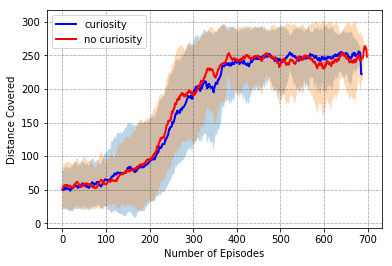

In [12]:
generate_graph('dense',save=True)

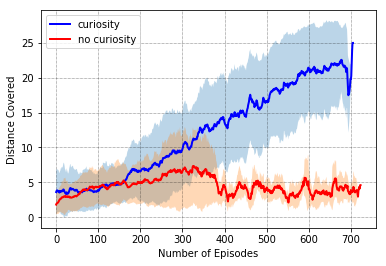

In [13]:
generate_graph('sparse',save=True)

In [33]:
def generate_graph_ppo(reward_type, save = False) : 
    curiosity = glob.glob('./trained_models_report/'+ 'curiosity_' + reward_type + '/train*.csv')
    default = glob.glob('../PPO/log_dir/curs_' + reward_type + '/train*.csv')
    list_ = []
    for file_ in curiosity:
        df = pd.read_csv(file_, header=None)
        list_.append(df.iloc[:,1])
    frame_cur = pd.concat(list_, axis = 1, ignore_index = True)  
    means_cur = np.nanmean(frame_cur.values, axis=1)
    std_cur = np.nanstd(frame_cur.values, axis=1)
    maxi_cur = np.nanmax(frame_cur.values, axis=1)
    mini_cur = np.nanmin(frame_cur.values, axis=1)
    n_itr_cur = frame_cur.shape[0]    
    list_ = []
    for file_ in default:
        df = pd.read_csv(file_, header=None)
        list_.append(df.iloc[:,0])
    frame_def = pd.concat(list_, axis = 1, ignore_index = True)
    means_def = np.nanmean(frame_def.values, axis=1)
    std_def = np.nanstd(frame_def.values, axis=1)
    maxi_def = np.nanmax(frame_def.values, axis=1)
    mini_def = np.nanmin(frame_def.values, axis=1)
    n_itr_def = frame_def.shape[0]    
    
    std_def[np.where(std_def == 0)] = 1.6*np.mean(std_def)
    
    plt.plot(moving_average(means_cur,10), color='blue', label= 'a3c curiosity',  linewidth=2)
    plt.fill_between(np.arange(n_itr_cur-9), moving_average(means_cur + std_cur,10), moving_average(means_cur - std_cur,10) , alpha=0.3 )
    plt.plot(moving_average(means_def,10), color='red', label = 'ppo curiosity',  linewidth=2)
    plt.fill_between(np.arange(n_itr_def-9), moving_average(means_def + std_def,10) , moving_average(means_def - std_def, 10) , alpha=0.3 )
    plt.legend(loc='upper left')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Distance Covered')
    plt.grid()
    if save : 
        plt.savefig('../figures/' + reward_type + '_ppo_plot.png')
    plt.show()


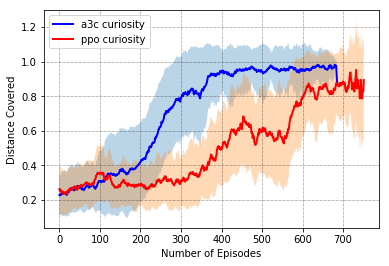

In [28]:
generate_graph_ppo('dense', save=True)

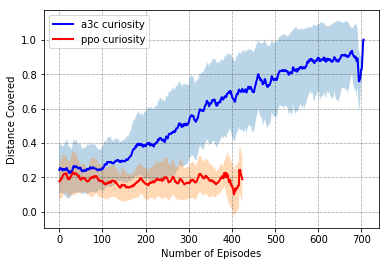

In [35]:
generate_graph_ppo('sparse', save=True)